In [71]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
from transformers import AutoTokenizer
from gen_tools import (
    FRED_T5_MODEL_NAME,
    INPUT_TOKEN_LIMIT_FRED_T5,
    TASK_PROMPT,
    MIN_TEXT_TOKENS_FOR_SUMMARIZATION,
    GEMINI_API_KEY,
    GEMINI_MODEL_NAME_PRIMARY
)
import gen_tools
from datasets import load_dataset
import google.generativeai as genai
import os

HF_DATASET_NAME = "cointegrated/taiga_stripped_rest"
HF_DATASET_SPLIT = "NPlus1"
OUTPUT_JSONL_FILE = "nplus1_generated_summaries.jsonl"
PROCESSED_INDICES_FILE = "nplus1_processed_indices.txt"
FINAL_HF_DATASET_PATH = "nplus1_gemini"

tokenizer = AutoTokenizer.from_pretrained(FRED_T5_MODEL_NAME)

In [73]:
tokens_in_task_prompt_fred_t5 = len(tokenizer(TASK_PROMPT, add_special_tokens=False)['input_ids'])
NUM_SPECIAL_TOKENS_FOR_FRED_T5_INPUT = 1
MAX_TEXT_TOKENS_FOR_FRED_T5_COMPATIBLE_INPUT = INPUT_TOKEN_LIMIT_FRED_T5 - \
                                               tokens_in_task_prompt_fred_t5 - \
                                               NUM_SPECIAL_TOKENS_FOR_FRED_T5_INPUT

In [74]:
raw_dataset = load_dataset(HF_DATASET_NAME, split=HF_DATASET_SPLIT)
print(f"Loaded '{HF_DATASET_SPLIT}' split with {len(raw_dataset)} examples.")

Loaded 'NPlus1' split with 7000 examples.


In [75]:
prepared_dataset_for_gemini = gen_tools.preprocess_and_filter_dataset_with_exact_deduplication(
    raw_dataset,
    tokenizer,
    MAX_TEXT_TOKENS_FOR_FRED_T5_COMPATIBLE_INPUT,
    MIN_TEXT_TOKENS_FOR_SUMMARIZATION
)

Starting preprocessing. Initial size: 7000
Targeting max text tokens for processing: 1017


Cleaning, Truncating, and Exact Deduplicating:   0%|          | 0/7000 [00:00<?, ?it/s]

Finished preprocessing. Exact duplicates found and skipped: 1
Filtered dataset size after exact deduplication: 6853


In [76]:
prepared_dataset_for_gemini

Dataset({
    features: ['file', 'processed_text', 'processed_text_tokens'],
    num_rows: 6853
})

<Axes: >

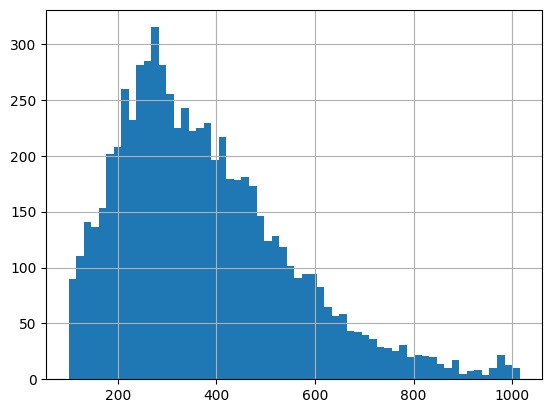

In [77]:
prepared_dataset_for_gemini.to_pandas()['processed_text_tokens'].hist(bins=60)

In [78]:
genai.configure(api_key=GEMINI_API_KEY)
model_gemini = genai.GenerativeModel(GEMINI_MODEL_NAME_PRIMARY)

In [79]:
gen_tools.generate_summaries_resumable_full_stats(prepared_dataset_for_gemini, model_gemini, tokenizer, PROCESSED_INDICES_FILE, OUTPUT_JSONL_FILE)

Loaded 6853 already processed indices.
No new items to process.


In [80]:
processed_indices = []
if os.path.exists(PROCESSED_INDICES_FILE): 
    with open(PROCESSED_INDICES_FILE) as f:
        processed_indices = [int(line.strip()) for line in f if line.strip()]
len(processed_indices) == len(set(processed_indices)), len(processed_indices)

(True, 6853)

In [81]:
final_dataset = gen_tools.create_final_huggingface_dataset_from_jsonl(OUTPUT_JSONL_FILE, FINAL_HF_DATASET_PATH)
final_dataset

Created Hugging Face dataset with 6853 examples from JSONL.
Saving Hugging Face dataset to nplus1_gemini...


Saving the dataset (0/1 shards):   0%|          | 0/6853 [00:00<?, ? examples/s]

Hugging Face dataset saved.


Dataset({
    features: ['file', 'text', 'summaries'],
    num_rows: 6853
})